# Reduced Model attempt 17: Parameter Sensitivity Analysis
In this notebook, we will perform sensitivity analysis to see what parameters are more important and which aren't, maybe we can remove particular reverse reactions.

In [1]:
from auto_reduce import *
from auto_reduce.utils import get_ODE
import matplotlib.pyplot as plt
from auto_reduce.utils import reduce

import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()
from bokeh.layouts import row

import colorcet

from sbml_to_ode2 import *
from scipy.integrate import odeint
import numpy as np
from sympy import *
from sympy.utilities.lambdify import lambdify
from sympy.abc import t

Loading BokehJS ...

## Copy functions
---

In [2]:
# Compute Jacobian
import warnings
def compute_J(fun, x, params_values, **kwargs):
    '''
    Compute the Jacobian J = df/dx at a point x.
    Returns a matrix of size n x n.
    Uses fourth-order central difference method to compute Jacobian
    '''
    n = len(x)
    #print('n',n)
   # print("PANIC")
    var = x
    # initialize J
    J = np.zeros( (n, len(x)) )   
    P = params_values 
    # jfun = nd.Jacobian(lambda x: fun_ode(0, x, P), **kwargs) # Using numdifftools
    # return jfun(x)
    # store the variable with respect to which we approximate the differentiation (df/dvar)
    X = var 
    for i in range(n):
        for j in range(len(var)):
            F = np.zeros( (4,1) )
            h = X[j]*0.01
            # Gets O(4) central difference on dfi/dvarj
            if h != 0:
                var = X
                var[j] = X[j] + 2*h
                f = fun(var, P)
                F[0] = f[i]
                var[j] = X[j] + h
                f = fun(var, P)
                F[1] = f[i]
                var[j] = X[j] - h
                f = fun(var, P)
                F[2] = f[i]
                var[j] = X[j] - 2*h
                f = fun(var, P)
                F[3] = f[i]
                #Store appro var. dfi/dvarj into J
                J[i,j]= (-F[0] + 8*F[1] - 8*F[2] + F[3])/(12*h) 
                # Error check
                if J[i, j] == np.Inf:
                    warnings.warn('Inf found')
                    J[i, j] = 1
                elif J[i, j] == np.NaN:
                    warnings.warn('NaN found')
                    J[i, j] = 0
    return J

In [3]:
def compute_Zj(fun, x, j, params_values, **kwargs):
    '''
    Compute Z_j, i.e. df/dp_j at a particular timepoint k for the parameter p_j. 
    Returns a vector of size n x 1. 
    '''
    n = len(x)
    Z = np.zeros(n)    
    P_holder = params_values
    # For each state
    for i in range(n):
        P = P_holder
        F = np.zeros( (4,1) ) # For 4th order difference
        h = P[j]*0.01 # Small parameter for this parameter
        # Gets O(4) central difference on dfi/dpj
        if h != 0:
            P[j] = P_holder[j] + 2*h
            f = fun(x, P)
            F[0] = f[i]
            P[j] = P_holder[j] + h
            f = fun(x, P)
            F[1] = f[i]
            P[j] = P_holder[j] - h
            f = fun(x, P)
            F[2] = f[i]
            P[j] = P_holder[j] - 2*h
            f = fun(x, P)
            F[3] = f[i]
            #Store approx. dfi/dpj into Z
            Z[i] = (-F[0] + 8*F[1] - 8*F[2] + F[3])/(12*h)   
            if Z[i] == np.Inf:
                warnings.warn('Inf found')
                Z[i] = 1
            elif Z[i] == np.NaN:
                warnings.warn('NaN found')
                Z[i] = 0
    return Z





In [4]:
import tqdm
def compute_SSM(fun, solutions, params_values, timepoints, normalize = False, **kwargs):
    '''
    Returns the sensitivity coefficients S_j for each parameter p_j. 
    Solutions is the ODE solution to fun for timepoints.
    Solutions is of shape (len(timepoints), n), where n is the len(x).
    The sensitivity coefficients are written in a sensitivity matrix SSM of size len(timepoints) x len(params) x n
    If normalize argument is true, the coefficients are normalized by the nominal value of each paramneter.
    '''
    from scipy.integrate import odeint
    
    def sens_func(t, x, J, Z):
        # forms ODE to solve for sensitivity coefficient S
        dsdt = J@x + Z
        return dsdt
    
    timepoints_ssm = timepoints
    P = params_values
    n = len(solutions[0])
    S0 = np.zeros(n) # Initial value for S_i  
    
    SSM = np.zeros( (len(timepoints), len(P), n) )
    xs = solutions
    print('xs',xs)
    xs = np.reshape(xs,(len(timepoints), n))
    # Solve for SSM at each time point 
    for k in range(len(timepoints)): 
        print('k',k)
        timepoints = timepoints_ssm[0:k+1]
        if len(timepoints) == 1:
            continue
        # get the jacobian matrix
#         print(xs[k,:])
        J = compute_J(lambda x, params_values: fun(0, xs[k,:], params_values), xs[k,:], params_values, **kwargs)
#         print(J)
        #Solve for S = dx/dp for all x and all P (or theta, the parameters) at time point k
        for j in range(len(P)):
            # print('for parameter',P[j])
            # get the pmatrix
            Zj = compute_Zj(lambda x, params_values: fun(0, xs[k,:], params_values), xs[k,:], j, params_values, **kwargs)
            # solve for S
           # print("OK", J@x + Zj)
            sens_func_ode = lambda t, x : sens_func(t, x, J, Zj)
            
            sol = odeint(sens_func_ode, S0, timepoints, tfirst = True)
            S = sol
            S = np.reshape(S, (len(timepoints), n))
            SSM[k,j,:] = S[k,:]
    if normalize:
        SSM = normalize_SSM(SSM, xs, params_values) #Identifiablity was estimated using an normalized SSM
    return SSM

def normalize_SSM(SSM, solutions, params_values):
    '''
    Returns normalized sensitivity coefficients. 
    Multiplies each sensitivity coefficient with the corresponding parameter p_j
    Divides the result by the corresponding state to obtain the normalized coefficient that is returned.
    '''
    n = np.shape(solutions)[1]
    SSM_normalized = np.zeros(np.shape(SSM))
    for j in range(len(params_values)):
        for i in range(n):
            SSM_normalized[:,j,i] = np.divide(SSM[:,j,i]*params_values[j], solutions[:,i]) 
    return SSM_normalized




--- 
## Sensitivity Analysis
### Reduced Model 5

In [5]:
%run sbml_to_ode2.py

In [6]:
filename = 'CRN_GOOD.xml'
x,f,P,params_values,x_init = sbml_to_ode2(filename)
#print(x_init)
nouts = 1
n = len(x)
# Make ATP main output
C = np.zeros((nouts, n), dtype = int)
C[0][1] = 1 
C = C.tolist()

# Setup system
timepoints_ode = np.linspace(0,75,75)

error_tol = 100
nstates_tol = 1

sys = System(x, f, params = P, params_values = params_values, C = C, x_init = x_init)

# sys_ode = get_ODE(sys, timepoints_ode)
# sol = sys_ode.solve_system()

species_to_remove = [5,6,9,10,13, 14,17,18,23,24,28,29,31,32,
                 35,36,39,40,43,44,47,48,51,52,55,56,59,60,63,64]

timescale_list = []
for i in species_to_remove:
    timescale_list.append(x[i])

# Get appropriate list of complexes that are not in timescale_list
# What you should pass into solve_timescale_separation
update_timescale = []
for item in x:
    if item not in timescale_list:
        update_timescale.append(item)    
#update_timescale

timepoints_ssm = np.linspace(0,75,75)
timepoints_ode = np.linspace(0, 75, 75)
sys_reduce = reduce(sys, timepoints_ode, timepoints_ssm)

aa,bb = sys_reduce.solve_timescale_separation(update_timescale)
print('the ATP error is:',sys_reduce.get_error_metric(aa))

sys_ode = get_ODE(aa, timepoints_ode)
sol = sys_ode.solve_system()
print(type(sol))


p = bokeh.plotting.figure(width = 475, height = 350, title = 'Reduced Model 5',
                             x_axis_label = 'Time (hrs)',
                             y_axis_label = 'Concentration (mM)')
#colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
colors = colorcet.b_glasbey_category10
#colors = colorcet.glasbey_warm
p.line(timepoints_ode, sol[:,1],line_width = 2, legend_label = 'atp', color = colors[3])
p.line(timepoints_ode, sol[:,2], line_width = 2,legend_label = 'glucose', color = colors[0])
p.line(timepoints_ode, sol[:,34], line_width = 2,legend_label = 'isobutanol', color = colors[1])


p.legend.click_policy = 'hide'
bokeh.io.show(p)

attempting to retain : [0, 1, 2, 3, 4, 7, 8, 11, 12, 15, 16, 19, 20, 21, 22, 25, 26, 27, 30, 33, 34, 37, 38, 41, 42, 45, 46, 49, 50, 53, 54, 57, 58, 61, 62, 65, 66, 67]


/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/sympy/core/relational.py:470: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  deprecated_since_version="1.5"


Successful time-scale separation solution obtained.
the ATP error is: 1192.6103862127325
<class 'numpy.ndarray'>


In [7]:
len(sol[0])

38

In [8]:

p1 = bokeh.plotting.figure(width = 475, height = 350, title = 'Reduced Model 5',
                             x_axis_label = 'Time (hrs)',
                             y_axis_label = 'Concentration (mM)')
#colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
colors = colorcet.b_glasbey_category10
#colors = colorcet.glasbey_cool
for i in range(len(sol[:,0])):
    if i == 38:
        break
    p1.line(timepoints_ode, sol[:,i], line_width = 2, color = colors[i])
# p.line(timepoints_ode, sol[:,1],line_width = 2, legend_label = 'atp', color = colors[3])
# p.line(timepoints_ode, sol[:,2], line_width = 2,legend_label = 'glucose', color = colors[0])
# p.line(timepoints_ode, sol[:,34], line_width = 2,legend_label = 'isobutanol', color = colors[1])


p.legend.click_policy = 'hide'
bokeh.io.show(p1)

In [9]:
species_to_remove = [5,6,9,10,13, 14,17,18,23,24,28,29,31,32,
                 35,36,39,40,43,44,47,48,51,52,55,56,59,60,63,64]


In [10]:
all_specs = np.arange(0,len(x))
#have_specs = all_specs
#for remove in species_to_remove:
have_specs = np.delete(all_specs,species_to_remove)
have_specs

array([ 0,  1,  2,  3,  4,  7,  8, 11, 12, 15, 16, 19, 20, 21, 22, 25, 26,
       27, 30, 33, 34, 37, 38, 41, 42, 45, 46, 49, 50, 53, 54, 57, 58, 61,
       62, 65, 66, 67])

In [11]:
enz_list = [0, 7, 11, 15, 19, 25, 30, 33, 37, 41, 45, 49, 53, 57, 61]
# indices for gluc, atp, nadp, pi
mol_list = [2, 1, 20, 26]

In [12]:
x_init = np.zeros(len(have_specs))
for i,num in enumerate(have_specs):
    if num in enz_list:
        x_init[i] = 0.15
        print(num)
    elif num in mol_list:
        x_init[i] = 30
    elif num == 65:
        x_init[i] = 2.
    else:
        #continue
        x_init[i] = 0

0
7
11
15
19
25
30
33
37
41
45
49
53
57
61


In [13]:
x_init

array([ 0.15, 30.  , 30.  ,  0.  ,  0.  ,  0.15,  0.  ,  0.15,  0.  ,
        0.15,  0.  ,  0.15, 30.  ,  0.  ,  0.  ,  0.15, 30.  ,  0.  ,
        0.15,  0.15,  0.  ,  0.15,  0.  ,  0.15,  0.  ,  0.15,  0.  ,
        0.15,  0.  ,  0.15,  0.  ,  0.15,  0.  ,  0.15,  0.  ,  2.  ,
        0.  ,  0.  ])

In [14]:
from sympy import Symbol

In [15]:
t = Symbol('t')



# for reduced model
x = update_timescale
f = aa.f
x_init = x_init
param_eval_f = [None]*len(f)

func = lambdify([t, x, P], f)
func_p = lambdify([t, x], param_eval_f)

x_point = x_init
# Compute Jacobian at x_point
J = compute_J(lambda x, params_values: func(0, x, params_values), x_point, params_values)
print('J',J)
print(len(J))

# Compute sensitivity wrt 2nd parameter at x_point
Zj = compute_Zj(lambda x, params_values: func(0, x, params_values), x_point, 1, params_values) 
print('zj',Zj)
print(len(Zj))
timepoints = timepoints_ode
#SSM = np.reshape(SSM, (len(timepoints), len(params_values), n))

J [[ 2.02109934e-10  1.01054967e-12  1.13686838e-12 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-6.74971876e+03 -4.87485938e+01 -3.37485938e+01 ... -2.25000000e+02
   0.00000000e+00  0.00000000e+00]
 [-6.74971876e+03 -3.37485938e+01 -3.37485938e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00 -1.50000000e+01  0.00000000e+00 ... -2.25000000e+02
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.50000000e+01  0.00000000e+00 ...  2.25000000e+02
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
38
zj [ 1.01054967e-11  2.81225861e-02  2.81225861e-02 -2.81225861e-02
 -2.81225861e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+0

In [16]:
J@x + Zj

array([2.02109933727317e-10*enzyme_hex + 1.01054966863659e-12*metabolite_atp + 1.13686837721616e-12*molecule_glucose + 1.01054966863659e-11,
       -225.0*enzyme_atpase - 6749.71876171811*enzyme_hex - 48.7485938085906*metabolite_atp - 33.7485938085896*molecule_glucose + 0.0281225860817358,
       -6749.71876171821*enzyme_hex - 33.7485938085911*metabolite_atp - 33.7485938085911*molecule_glucose + 0.0281225861019468,
       6749.71876171841*enzyme_hex + 33.7485938085921*metabolite_atp + 33.7485938085921*molecule_glucose - 0.0281225860918413,
       6749.71876171841*enzyme_hex + 33.7485938085921*metabolite_atp + 33.7485938085921*molecule_glucose - 0.0281225860918413,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0,
       -225.000000000004*enzyme_atpase - 15.0000000000003*metabolite_atp,
       225.000000000004*enzyme_atpase + 15.0000000000003*metabolite_atp,
       0], dtype=object)

In [17]:
len(x)

38

In [18]:
SSM = compute_SSM(func, sol, params_values, timepoints, normalize = True)  

xs [[1.50000000e-01 3.00000000e+01 3.00000000e+01 ... 2.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.50000000e-01 1.24299063e+00 1.52167784e+00 ... 3.00712782e-02
  1.27401047e-01 1.84252768e+00]
 [1.50000000e-01 2.75750365e+01 7.13496985e-15 ... 1.49567075e-02
  1.74113426e+00 2.43909030e-01]
 ...
 [1.50000000e-01 3.07690887e-02 3.58383215e-72 ... 1.22423341e-02
  1.66091808e-03 1.98609675e+00]
 [1.50000000e-01 2.78662861e-02 3.35206195e-72 ... 1.22415160e-02
  1.50397793e-03 1.98625451e+00]
 [1.50000000e-01 2.52460676e-02 3.15543352e-72 ... 1.22407754e-02
  1.36233808e-03 1.98639689e+00]]
k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11
k 12
k 13
k 14
k 15
k 16
k 17
k 18
k 19
k 20
k 21
k 22
k 23
k 24
k 25
k 26
k 27
k 28
k 29
k 30
k 31
k 32
k 33
k 34
k 35
k 36
k 37
k 38
k 39
k 40
k 41
k 42
k 43
k 44
k 45
k 46
k 47
k 48
k 49
k 50
k 51
k 52
k 53
k 54
k 55
k 56
k 57
k 58
k 59
k 60


/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


k 61
k 62
k 63
k 64
k 65
k 66
k 67
k 68
k 69
k 70
k 71
k 72
k 73
k 74


/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


In [19]:
nouts=1
C = np.zeros((nouts, 38), dtype = int)
C[0][1] = 1 # Let's look at ATP

C = C.tolist()

In [20]:
# from auto_reduce.utils import get_SSM
# timepoints_ssm = np.linspace(0,100,10)
# sys_ssm = get_SSM(sys, timepoints_ssm)

print('h')# len(timepoints) x len(params) x len(states)
out_Ss = []
for i in range(len(params_values)):
    out_Ss.append((np.array(C)@(SSM[:,i,:].T)))
out_Ss = np.reshape(np.array(out_Ss), (len(timepoints_ssm), len(params_values), nouts))

h


In [21]:
len(C[0])

38

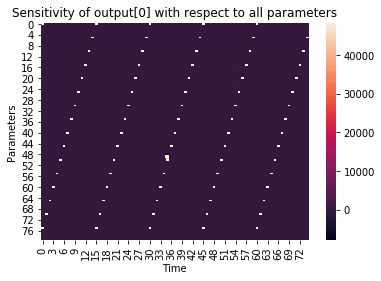

In [22]:
import seaborn as sn
for j in range(nouts):
   # plt.figure(figsize=(20,10))
    sn.heatmap(out_Ss[:,:,j].T)
   # plt.draw_if_interactivefigsi
    plt.xlabel('Time')
    plt.ylabel('Parameters')
    plt.title('Sensitivity of output[{0}] with respect to all parameters'.format(j))
    plt.show()
    

## COPY functions
---

## sensitivity analysis cont

In [23]:
import matplotlib.pyplot as plt
import tqdm


In [24]:
from auto_reduce.utils import get_SSM
timepoints_ssm = np.linspace(0,100,10)
print('0')
sys_ssm = get_SSM(sys, timepoints_ssm)
print('1')

0
1


In [25]:
print(type(sol))
print(type(sys_ode))
print(type(sys_ssm))
print(type(sys))
print(type(sol))

<class 'numpy.ndarray'>
<class 'auto_reduce.ode.ODE'>
<class 'auto_reduce.local_sensitivity.SSM'>
<class 'auto_reduce.system.System'>
<class 'numpy.ndarray'>


In [26]:
Ss = sys_ssm.compute_SSM() 

/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


TypeError: can't convert expression to float

In [ ]:
# from auto_reduce.utils import get_SSM
# timepoints_ssm = np.linspace(0,100,10)
# print('0')
# sys_ssm = get_SSM(sys, timepoints_ssm)
# print('1')

print('2')# len(timepoints) x len(params) x len(states)
out_Ss = []
for i in tqdm.tqdm(range(len(params))):
    out_Ss.append((np.array(C)@(Ss[:,i,:].T)))
out_Ss = np.reshape(np.array(out_Ss), (len(timepoints_ssm), len(params), nouts))

In [ ]:
import seaborn as sn
for j in range(nouts):
    sn.heatmap(out_Ss[:,:,j].T)
    plt.xlabel('Time')
    plt.ylabel('Parameters')
    plt.title('Sensitivity of output[{0}] with respect to all parameters'.format(j))
    plt.show()